In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

# Neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision

import h5py
import os

from CNNModels import *
from CNNTrain import *

In [2]:
h0_link = "/mnt/gs18/scratch/users/tranant2/Wierd_Distro2/data_0.hdf5"
with h5py.File(h0_link, 'r') as f:
    print(f['Input'].keys())
with h5py.File(h0_link, 'r') as f:
    print(f.keys())    

<KeysViewHDF5 ['33x33_0', '33x33_1', '33x33_2', '33x33_3', '33x33_4', 'dww', 'l', 'phi', 'px', 'py', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'x', 'y']>
<KeysViewHDF5 ['00_entry', '01_drift', '02_eq3d', '03_mult', '04_drift', '05_drift', '06_mhb4', '07_scrch', '08_drift', '09_eq3d', '10_eq3d', '11_drift', '12_eq3d', '13_eq3d', '14_drift', '15_eq3d', '16_eq3d', '17_drift', '18_eq3d', '19_eq3d', '20_eq3d', '21_drift', 'Input']>


In [3]:
class H5Dataset(torch.utils.data.Dataset):
    # Given a list of h5_path files, extract the voltage, distribution, and loss values
    def __init__(self, h5_paths, transform=False, size = 94):
        self.h5_paths = h5_paths
        self.transform=transform
        self.size = size
        # Code to get data from hdf5 files and put into memory
        i=0
        self.voltages, distro, output= self.extract_data(h5_paths[i])
        self.distro_0 = distro[0]
        self.distro_1 = distro[1]
        self.distro_2 = distro[2]
        self.distro_3 = distro[3]
        self.distro_4 = distro[4]
        self.output_0 = output[0]
        self.output_1 = output[1]
        self.output_2 = output[2]
        self.output_3 = output[3]
        i+=1
        while(i<len(h5_paths)):
            if h5_paths[1].endswith('.hdf5'):
                a, b, c = self.extract_data(h5_paths[i])
                self.voltages = np.concatenate((self.voltages,a))
                self.distro_0 = np.concatenate((self.distro_0,b[0]))
                self.distro_1 = np.concatenate((self.distro_1,b[1]))
                self.distro_2 = np.concatenate((self.distro_2,b[2]))
                self.distro_3 = np.concatenate((self.distro_3,b[3]))
                self.distro_4 = np.concatenate((self.distro_4,b[4]))
                self.output_0 = np.concatenate((self.output_0,c[0]))
                self.output_1 = np.concatenate((self.output_1,c[1]))
                self.output_2 = np.concatenate((self.output_2,c[2]))
                self.output_3 = np.concatenate((self.output_3,c[3]))
            i+=1
        # Make sure all particles that starts are inside the aperature
        distro_sum = self.distro_0.sum(axis=(1,2,3))
        mask = distro_sum>60000
        self.voltages = self.voltages[mask]
        self.distro_0 = self.distro_0[mask]
        self.distro_1 = self.distro_1[mask]
        self.distro_2 = self.distro_2[mask]
        self.distro_3 = self.distro_3[mask]
        self.distro_4 = self.distro_4[mask]
        self.output_0 = self.output_0[mask]
        self.output_1 = self.output_1[mask]
        self.output_2 = self.output_2[mask]
        self.output_3 = self.output_3[mask]
        # normalizing the data from [-1,1]
        self.voltages = self.voltages/8
        self.len = len(self.output_0)
        
        self.resize = torchvision.transforms.Resize((self.size,self.size))

    def __getitem__(self, index):
        if (self.transform):
            return ((self.voltages[index],  # voltages on quad
                     self.Resize(self.distro_0[index]),  # Distribution images
                     self.Resize(self.distro_1[index]),
                     self.Resize(self.distro_2[index]),
                     self.Resize(self.distro_3[index]),
                     self.Resize(self.distro_4[index])),
                    (self.output_0[index],  # outputs
                     self.output_1[index],
                     self.output_2[index],
                     self.output_3[index]))
        else:
            return ((self.voltages[index],  # voltages on quad
                     self.distro_0[index],  # Distribution images
                     self.distro_1[index],
                     self.distro_2[index],
                     self.distro_3[index],
                     self.distro_4[index]),
                    (self.output_0[index],  # outputs
                     self.output_1[index],
                     self.output_2[index],
                     self.output_3[index]))

    def __len__(self):
        return self.len
    
    def Resize(self, data):
        s = np.array(data).shape
        tempdata = torch.zeros((self.size, self.size, s[-1]))
        for i in range(s[-1]):
            tempdata[:,:,i] = self.resize(torch.from_numpy(data[:,:,i]).squeeze().unsqueeze(dim=0))
        return np.array(tempdata)
    
    def get_memory(self):
        """
        Return memory in GBs
        """
        memory = self.voltages.nbytes
        memory += self.distro_0.nbytes
        memory += self.distro_1.nbytes
        memory += self.distro_2.nbytes
        memory += self.distro_3.nbytes
        memory += self.distro_4.nbytes
        memory += self.output_0.nbytes
        memory += self.output_1.nbytes
        memory += self.output_2.nbytes
        memory += self.output_3.nbytes # float32 has 4 byte
        memory = memory/1028**3
        return memory
    
    def extract_data(self, file):
        with h5py.File(file, 'r') as f:
            v = pd.DataFrame(f['Input/v1'])
            nonzero = (v.shape[0]-(v==0).sum())[0]  # Get number of nonzero values from file
            print(nonzero)
            v1 = f['Input/v1'][:nonzero]
            v2 = f['Input/v2'][:nonzero]
            v3 = f['Input/v3'][:nonzero]
            v4 = f['Input/v4'][:nonzero]
            v5 = f['Input/v5'][:nonzero]
            v6 = f['Input/v6'][:nonzero]
            v = pd.DataFrame([v1,v2,v3,v4,v5,v6]).T  # This creates a vector of voltage data

            exit_left = [None]*4
            exit_left[0] = f['11_drift/#of_part_left'][:nonzero]  #Get number of particles after first quad pair
            exit_left[1] = f['14_drift/#of_part_left'][:nonzero]  #Get number of particles after second quad pair
            exit_left[2] = f['17_drift/#of_part_left'][:nonzero]  #Get number of particles after third quad pair
            exit_left[3] = f['21_drift/#of_part_left'][:nonzero]  #Get number of particles left at the last element
            ploss_0 = pd.DataFrame(exit_left[0]) 
            ploss_1 = pd.DataFrame(exit_left[1]) 
            ploss_2 = pd.DataFrame(exit_left[2]) 
            ploss_3 = pd.DataFrame(exit_left[3]) 

            distro = [None]*5
            distro[0] = f['Input/33x33_0'][:nonzero,:,:,:]
            distro[1] = f['Input/33x33_1'][:nonzero,:,:,:]
            distro[2] = f['Input/33x33_2'][:nonzero,:,:,:]
            distro[3] = f['Input/33x33_3'][:nonzero,:,:,:]
            distro[4] = f['Input/33x33_4'][:nonzero,:,:,:]
            print(distro[0].shape)

        voltage = v.values
        distro = np.array(distro)
        loss = np.array(exit_left)
        return (voltage, distro, loss)

In [4]:
# Make a function to get data from a list of files
hdf5_dir = "/mnt/scratch/tranant2/Wierd_Distro2"
files = os.listdir(hdf5_dir)
hdf5_files1 = [(hdf5_dir + '/'+i) for i in files ]
hdf5_files1

['/mnt/scratch/tranant2/Wierd_Distro2/data_0.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_9.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_28.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_22.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_2.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_29.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_27.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_4.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_3.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_31.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_13.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_24.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_30.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_21.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_7.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_26.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_6.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_17.hdf5',
 '/mnt/scratch/tranant2/Wierd_Distro2/data_15.hdf5',


In [5]:
dataset = H5Dataset(hdf5_files1[0:], transform=False)

256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)


In [6]:
dataset.__len__()

1071

In [7]:
test_loader = DataLoader(dataset=dataset, batch_size = 1000, shuffle=True)

In [8]:
print(f"Is GPU avaliable: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Got the: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/(1028**3)} GB")

Is GPU avaliable: True
Got the: Tesla K80
Total memory: 11.781983108519892 GB


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
examples = enumerate(test_loader)
batch_idx, (test_data, test_targets) = next(examples)

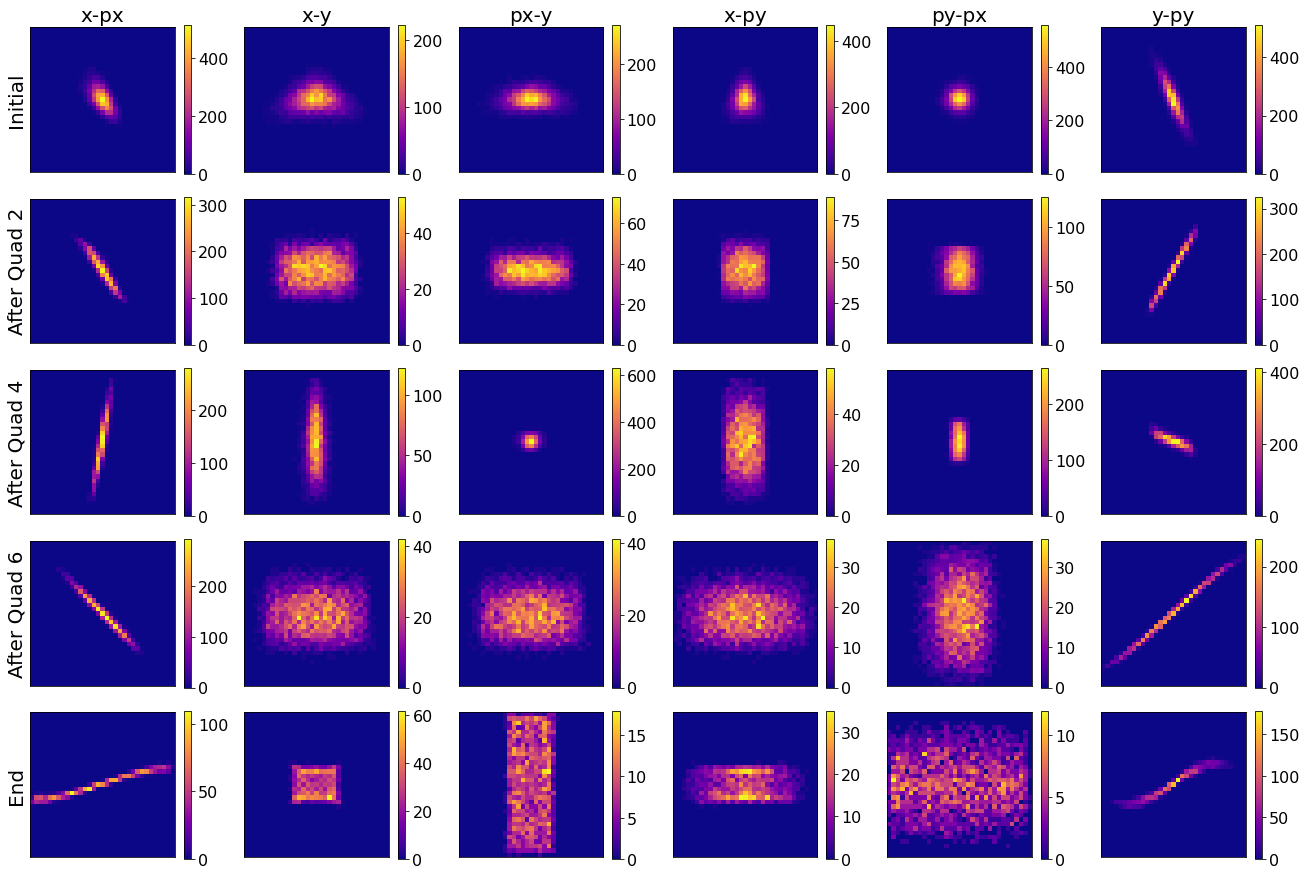

In [11]:
fig, ax = plt.subplots(5,6,figsize=(18,12))
nimg = 5
for j in range(5):
    for i in range(6):
        pc = ax[j,i].imshow(np.array(test_data[j+1])[nimg,:,:,i],
                            cmap='plasma',
                            interpolation='none',
                           aspect='equal')
        cbar = fig.colorbar(pc, ax=ax[j, i])
        cbar.ax.tick_params(labelsize=16)
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([], fontsize=14)
plt.tight_layout()

ax[0,0].set_title("x-px", fontsize=20)
ax[0,1].set_title("x-y", fontsize=20)
ax[0,2].set_title("px-y", fontsize=20)
ax[0,3].set_title("x-py", fontsize=20)
ax[0,4].set_title("py-px", fontsize=20)
ax[0,5].set_title("y-py", fontsize=20)

ax[0,0].set_ylabel("Initial", fontsize=20)
ax[1,0].set_ylabel("After Quad 2", fontsize=20)
ax[2,0].set_ylabel("After Quad 4", fontsize=20)
ax[3,0].set_ylabel("After Quad 6", fontsize=20)
ax[4,0].set_ylabel("End", fontsize=20)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/OriginalPhaseSpace_Sextupole_Final.png", dpi = 300, bbox_inches="tight")

In [12]:
learning_rate = 0.001
log_interval = 2

model = VAE().to(device)

In [13]:
model.load_state_dict(torch.load( f"/mnt/ufs18/home-032/tranant2/Desktop/MachineLearning/TRACK/CNN9/model__{1}.pth"), strict=False)

<All keys matched successfully>

In [14]:
voltages = test_data[0].to(device)
distro_0 = test_data[1].to(device)
distro_1 = test_data[2].to(device)
distro_2 = test_data[3].to(device)
distro_3 = test_data[4].to(device)
distro_4 = test_data[5].to(device)
output_0 = test_targets[0].to(device)
output_1 = test_targets[1].to(device)
output_2 = test_targets[2].to(device)
output_3 = test_targets[3].to(device)
with torch.no_grad():
    distro, losses = model(voltages=voltages,
                           distro0=distro_0,
                           distro1=distro_1,
                           distro2=distro_2,
                           distro3=distro_3,
                           distro4=distro_4,
                           output0=output_0,
                           output1=output_1,
                           output2=output_2,
                           output3=output_3)

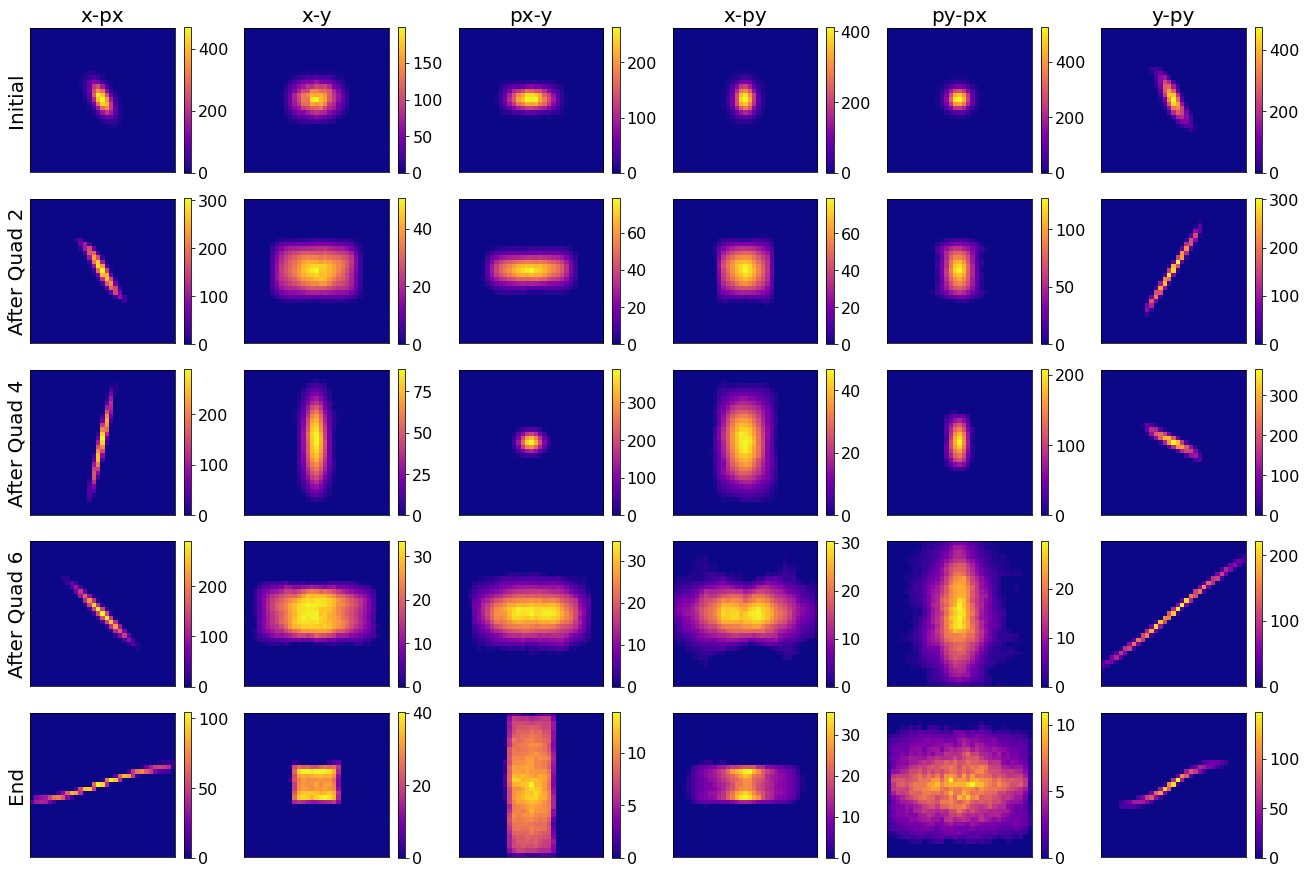

In [15]:
fig, ax = plt.subplots(5,6,figsize=(18,12))
nimg = 5
for j in range(5):
    for i in range(6):
        pc = ax[j,i].imshow(np.array(distro[j].cpu())[nimg,:,:,i],
                            cmap='plasma',
                            interpolation='none',
                           aspect='equal')
        cbar = fig.colorbar(pc, ax=ax[j, i])
        cbar.ax.tick_params(labelsize=16)
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([], fontsize=14)
plt.tight_layout()

ax[0,0].set_title("x-px", fontsize=20)
ax[0,1].set_title("x-y", fontsize=20)
ax[0,2].set_title("px-y", fontsize=20)
ax[0,3].set_title("x-py", fontsize=20)
ax[0,4].set_title("py-px", fontsize=20)
ax[0,5].set_title("y-py", fontsize=20)

ax[0,0].set_ylabel("Initial", fontsize=20)
ax[1,0].set_ylabel("After Quad 2", fontsize=20)
ax[2,0].set_ylabel("After Quad 4", fontsize=20)
ax[3,0].set_ylabel("After Quad 6", fontsize=20)
ax[4,0].set_ylabel("End", fontsize=20)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/ReconstructedPhaseSpace_Sextupole_Final.png", dpi = 300, bbox_inches="tight")

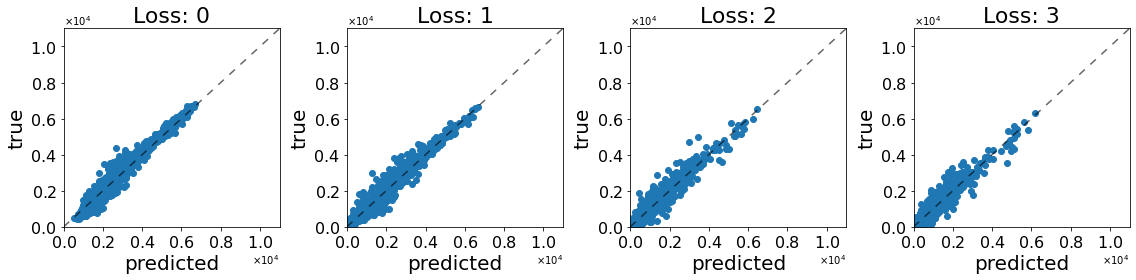

In [16]:
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    plt.scatter(losses[i].cpu(),test_targets[i])
    plt.xlabel('predicted', fontsize=20)
    plt.ylabel('true', fontsize=20)
    plt.xlim(0,11000)
    plt.ylim(0,11000)
    plt.title(f"Loss: {i}", fontsize=22)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ticklabel_format(axis='both', style='scientific', useMathText=True, scilimits=(0,0))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)), alpha=.6)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/Losses_Sextupole_Final.png", dpi = 300, bbox_inches="tight")

## Calculate error and sd

In [17]:
diff = np.zeros((4, losses[0].shape[0]))
for i in range(4):
    diff[i] = test_targets[i]-losses[i].cpu()  # If positive error, model tends to underestimate

In [18]:
for i in range(4):
    u = np.mean(diff[i])
    sd = np.std(diff[i])
    print(f"For the {i} loss location, mean:{u}. std:{sd}")

For the 0 loss location, mean:10.697534423828126. std:320.2431698396973
For the 1 loss location, mean:36.00314308166504. std:301.0832565892806
For the 2 loss location, mean:36.659998574256896. std:274.3431641158953
For the 3 loss location, mean:18.178604804992677. std:257.25643359960486


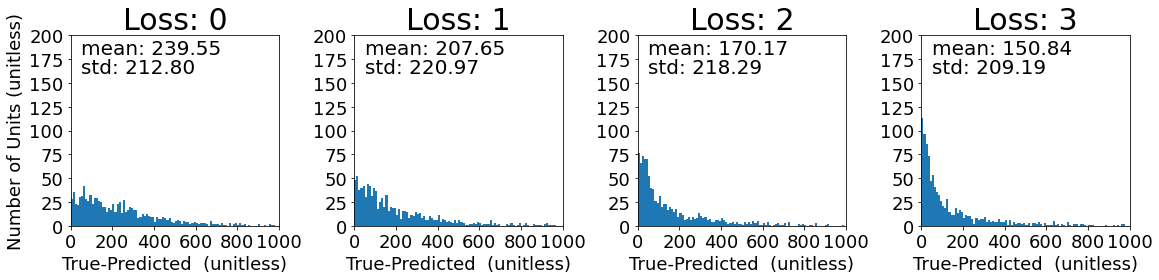

In [19]:
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    plt.hist(np.abs(diff[i]), np.arange(0,1000,10))
    plt.xlabel('True-Predicted  (unitless)', fontsize=18)
    if i == 0:
        plt.ylabel('Number of Units (unitless)', fontsize=18)
    plt.title(f"Loss: {i}", fontsize=30)
    plt.xlim(0,1000)
    plt.ylim(0,200)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    u = np.mean(np.abs(diff[i]))
    sd = np.std(np.abs(diff[i]))
    plt.text(50, 180, "mean: {:.2f}".format(u), fontsize=20)
    plt.text(50, 160, "std: {:.2f}".format(sd), fontsize=20)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/Histogram_Sextupole_Final0.png", dpi = 300, bbox_inches="tight")

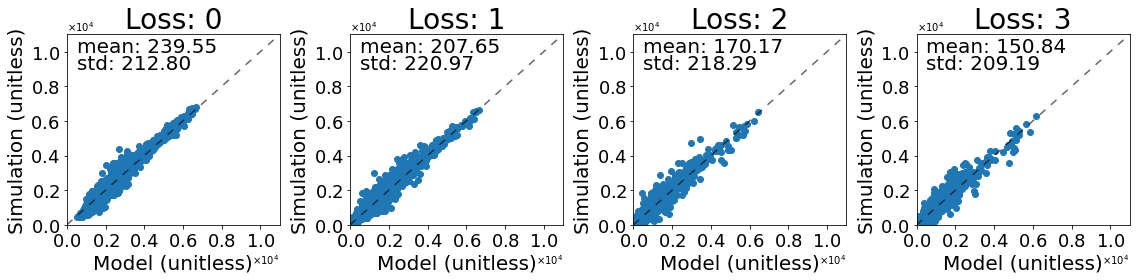

In [22]:
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.tight_layout()
    plt.scatter(losses[i].cpu(),test_targets[i])
    plt.xlabel('Model (unitless)', fontsize=20)
    plt.ylabel('Simulation (unitless)', fontsize=20)
    plt.xlim(0,11000)
    plt.ylim(0,11000)
    plt.title(f"Loss: {i}", fontsize=28)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ticklabel_format(axis='both', style='scientific', useMathText=True, scilimits=(0,0))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)), alpha=.6)
    u = np.mean(np.abs(diff[i]))
    sd = np.std(np.abs(diff[i]))
    plt.text(500, 10000, "mean: {:.2f}".format(u), fontsize=20)
    plt.text(500, 9000, "std: {:.2f}".format(sd), fontsize=20)
fig.savefig(f"/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9/Losses_Sextupole_Final_6.png", dpi = 300, bbox_inches="tight")